<a href="https://colab.research.google.com/github/Chia-Yin-Lee/fake-review-on-amazon-prac-/blob/main/fakereview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title show your CPU or GPU details
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2329925408329154270
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16981547064009957363
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
#@title connect google drive folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_AML/archive/

Mounted at /content/drive
/content/drive/MyDrive/SMU_MITB_AML/archive


In [ ]:
#@title device()
import torch
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [3]:
#@title import packages

import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import linear_model, tree, model_selection, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
import string, nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Data includes:

- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews


- HelpfulnessNumerator: Number of users who found the review helpful
- HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not
- Time: The date the review was published on Amazon in unix time

In [ ]:
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [ ]:
def cleanDF(df):
    '''
    Pass in a dataframe that contains an amazon review dataset to be cleaned.
    Returns cleaned dataframe.
    '''
    # convert unix time to timestamp
    modified_df = df.copy()
    new_time = []
    for t in modified_df['Time']:
        new_time.append(datetime.fromtimestamp(t))
    modified_df['Time'] = new_time

    # fill empty summaries with review text
    modified_df['Summary'].fillna(modified_df['Text'], inplace = True)

    # fill empty names with 'Amazon Customer'
    modified_df['ProfileName'].fillna('Amazon Customer', inplace = True)

    # remove rows with NaN
    modified_df = modified_df.dropna(axis = 0)

    # sort by time
    modified_df.sort_values(by = 'Time', inplace = True)

    # reset index
    modified_df = modified_df.reset_index().drop('index', axis = 1)

    return modified_df

In [ ]:
# cleaning df and saving it to new dataframe called clean_df
clean_df = cleanDF(df)
clean_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [ ]:
clean_df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [ ]:
# check if there are any duplicate rows

clean_df.duplicated().sum()

0

In [ ]:
clean_df['ProfileName'].value_counts()

C. F. Hill "CFH"                          451
O. Brown "Ms. O. Khannah-Brown"           421
Gary Peterson                             389
Rebecca of Amazon "The Rebecca Review"    365
Chris                                     363
                                         ... 
AcuTrainer                                  1
Freida Pryor                                1
Amy J. Yetter "amelia1901"                  1
Zandra                                      1
TechLover70                                 1
Name: ProfileName, Length: 218416, dtype: int64

In [ ]:
clean_df['UserId'].value_counts()

A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
AIMNG8MKGYT84       1
A34F7SYYEVJV84      1
A1X1XY3N5W704K      1
A2S1QJMVXU8H5T      1
A1GENHMJBIS42V      1
Name: UserId, Length: 256059, dtype: int64

In [ ]:
clean_df[clean_df['ProfileName'] == 'Amazon Customer']['UserId'].value_counts()

AGT3BYX5P9SLH     5
A2L86I1MFLXR93    3
A36BVYD0NT7Z0F    3
A6Y2WVJNHZBSJ     2
A2HSENLLAQXCTH    2
A29D7XVSBCLFLD    2
A1MV7H2G87CM2R    1
A2H7605OSHVIQ5    1
A1O83SA3VV31ZS    1
A2MUTSVQ6IC4ZX    1
A3775ONM8HGEQ3    1
A2TCBGD1CF35JF    1
A1P500QXEG3IUZ    1
A2P0P67Y55SNOX    1
A9FOFDH40Y6HD     1
A2LZDBA902001G    1
A3F0ESIF6YWCKB    1
A2A5TD0UI6MO      1
AC9U70TRGPDGJ     1
A2LYFY32LXQDON    1
AC0E8TXIYABB5     1
Name: UserId, dtype: int64

- Better to use UserId rather than ProfileName to identify each reviwer.
- Amazon Customer can include different people who did not give their profile name when commenting.

In [ ]:
# list out reviewers giving different profile names when commenting

userid_marked = []

d = defaultdict(list)
for i in clean_df.index:
    d[clean_df['UserId'][i]].append(clean_df['ProfileName'][i])
for key, value in d.items():
    if len(value) > 1:
        userid_marked.append(key)

inconsistent_name = []
for i in clean_df.index:
    if clean_df['UserId'][i] in userid_marked: inconsistent_name.append(1)
    else: inconsistent_name.append(0)

clean_df['inconsistent_name'] = inconsistent_name

In [ ]:
# people who has given the same products several reviews

groupby_clean_df = clean_df.groupby(['ProductId','UserId']).size().reset_index(name='count')
groupby_clean_df[groupby_clean_df['count'] > 1]

,ProductId,UserId,count
177,7310172001,AE9ZBY7WW3LIQ,2
188,7310172001,AJD41FBJD9010,6
344,7310172101,AE9ZBY7WW3LIQ,2
355,7310172101,AJD41FBJD9010,6
447,B00004CI84,A1K94LXX833JTT,3
...,...,...,...
560552,B009RB4GO4,A1N06XIVTDQMP,2
560581,B009RB4GO4,A21GDMT9JN2A5Y,2
560652,B009RB4GO4,A353Y7VBQHHW0T,2
560689,B009RB4GO4,A3QVP3B2VVJ9T0,2


In [ ]:
# days between the people who had given comments for the same products

time_delta = []
product_user_dict = {}

for i in clean_df.index:
    if (clean_df['ProductId'][i], clean_df['UserId'][i]) not in product_user_dict.keys():
        time_delta.append(0)
    else:
        t2 = clean_df['Time'][i]
        t1 = product_user_dict[(clean_df['ProductId'][i], clean_df['UserId'][i])]
        time_delta.append((t2 - t1).total_seconds() / 86400)
    product_user_dict[(clean_df['ProductId'][i], clean_df['UserId'][i])] = clean_df['Time'][i]

clean_df['time_delta'] = time_delta

In [ ]:
clean_df['nameProvided'] = np.where(clean_df['ProfileName'] != 'Amazon Customer', 1, 0)

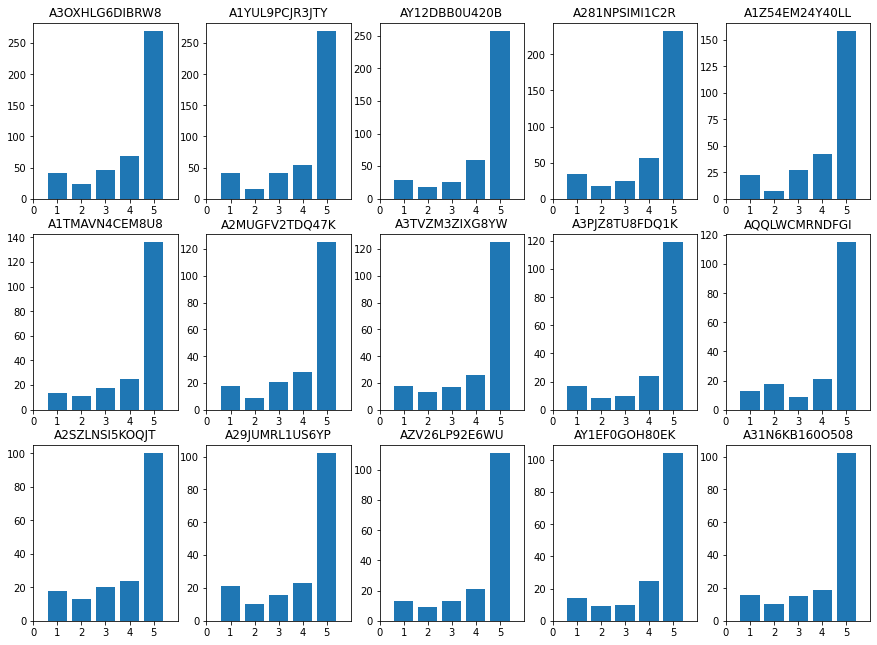

In [ ]:
# see the patterns of scores from those giving most of the reviews

plt.subplots(3,5, figsize=(15,11))

for i in range(0, 15):
    user = clean_df["UserId"].value_counts().index[i]
    data = clean_df['Score'][df['UserId'] == user].value_counts()

    plt.subplot(3,5,i+1)
    plt.bar(data.index, data.values)
    plt.title(user)
    plt.xlim(0,6)
    plt.xticks(range(6))
plt.show()

In [ ]:
# display if a reviewer only gave 5 star reviews or one star reviews

map_five = clean_df['Score'].groupby(clean_df['UserId']).agg(lambda x: (np.unique(x)==5).all()).to_dict()
map_one = clean_df['Score'].groupby(clean_df['UserId']).agg(lambda x: (np.unique(x)==1).all()).to_dict()
clean_df['User_five_star_only'] = clean_df['UserId'].map(map_five)
clean_df['User_one_star_only'] = clean_df['UserId'].map(map_one)

# boolen
clean_df['User_five_star_only'] = clean_df['User_five_star_only'].astype(int)
clean_df['User_one_star_only'] = clean_df['User_one_star_only'].astype(int)

In [ ]:
clean_df['Summary_word_count'] = clean_df['Summary'].str.split().str.len()
clean_df['Text_word_count'] = clean_df['Text'].str.split().str.len()

clean_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,inconsistent_name,time_delta,nameProvided,User_five_star_only,User_one_star_only,Summary_word_count,Text_word_count
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,0,0.0,1,1,0,4,74
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,0,0.0,1,1,0,12,78
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,0,0.0,1,1,0,2,29
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1,0.0,1,1,0,5,36
4,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1,0.0,1,1,0,5,36


In [ ]:
clean_df.to_csv('clean_df.csv')

In [5]:
clean_df = pd.read_csv('clean_df.csv')

In [ ]:
print(f'Reviews: {len(clean_df)}')
print(f'Products: {len(clean_df["ProductId"].value_counts())}')
print(f'User: {len(clean_df["UserId"].value_counts())}')
np.quantile(clean_df["ProductId"].value_counts().values, np.arange(0,1.05,0.05)).astype(int)

Reviews: 568454
Products: 74258
User: 256059


array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   3,
         3,   4,   5,   7,   9,  13,  26, 913])

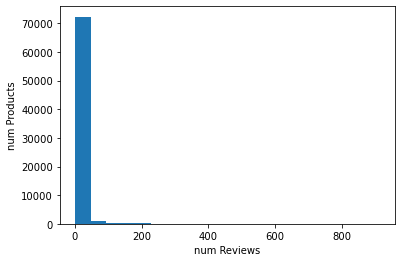

In [ ]:
# distribution of number of reviews per product

plt.figure()
plt.hist(clean_df['ProductId'].value_counts().values, bins=20)
plt.xlabel('num Reviews')
plt.ylabel('num Products')
plt.show()

Up until the 90th percentile, products have still not surpassed more than 13 reviews.

In [ ]:
#creating a dataframe that has the number of reviews per year, but segmented by whether or not the review was associated with a verified purchase
five_star_only = clean_df['User_five_star_only'].groupby(clean_df['Time'].dt.year).value_counts()
five_star_only = five_star_only.reset_index(level='Time').rename(columns={'User_five_star_only':'num'}).reset_index()

one_star_only = clean_df['User_one_star_only'].groupby(clean_df['Time'].dt.year).value_counts()
one_star_only = one_star_only.reset_index(level='Time').rename(columns={'User_one_star_only':'num'}).reset_index()

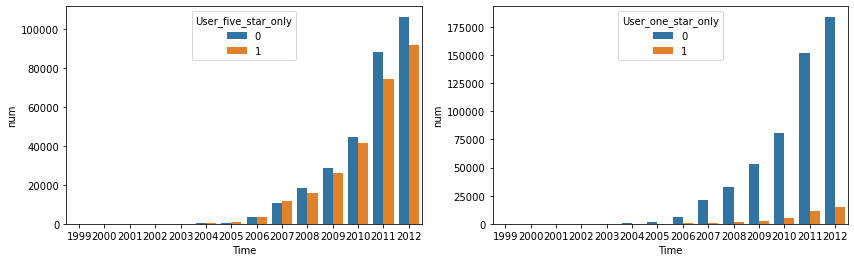

In [ ]:
# plotting number of reviews per year

hue_list = ['User_five_star_only', 'User_one_star_only']
data_list = [five_star_only, one_star_only]

plt.subplots(1, 2, figsize=(14,4))

for i in range(2):
    plt.subplot(1, 2, i+1)
    sns.barplot(x = 'Time', y = 'num', hue = hue_list[i], data = data_list[i])
plt.show()

- Before 2007, the number of users only giving 5 was more than the number of users who did not. This changed after 2007, though the numbers of 2 kinds of people were still close compared to the right plot.
- There may be businesses incentivizing people to post good reviews in exchange for their product and this may a new way businesses are able to get fake good reviews.
- It seems that it's more important to look at fake good reviews than for fake bad reviews, which maight come from competitors.

# Text

In [6]:
#@title Processing Data functions

ENGLISH_STOP_WORDS = stopwords.words('english')

def spl_tokenizer(sentence):
    '''
    Tokenizer with following specs:
    - removes english stopwords
    - removes punctuation
    - lemmatizes words
    '''
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    listofwords = sentence.split(' ')
    listoflemmatized_words = []

    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            token = WordNetLemmatizer().lemmatize(word)

            #add r_ prefix to indicate word is from review or s_ if from summary
            try:
                if tfidf.type == 'review':
                    token = 'r_' + token
                elif tfidf.type == 'summary':
                    token = 's_' + token
            except:
                pass

            listoflemmatized_words.append(token)

    return listoflemmatized_words

def sps_tokenizer(sentence):
    '''
    Tokenizer with following specs:
    - removes english stopwords
    - removes punctuation
    - stems words
    '''
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    listofwords = sentence.split(' ')
    listofstemmed_words = []
    stemmer = PorterStemmer()

    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            token = stemmer.stem(word)

            #add r_ prefix to indicate word is from review or s_ if from summary
            try:
                if tfidf.type == 'review':
                    token = 'r_' + token
                elif tfidf.type == 'summary':
                    token = 's_' + token
            except:
                continue
            listofstemmed_words.append(token)

    return listofstemmed_words


def tfidf(dataframe_column, tokenizer, min_df=0.02, max_df=0.8, ngram_range=(1,1)):
    '''
    For tokenization, need to determine what prefix (r_ or s_) to add to each token
    Retrieve the name of the column from which the tokens are generated
    '''
    column_name = dataframe_column.name

    # Assign an attribute (called type) to the tfidf function to indicate if the tokens are from review or summary
    if column_name == 'Text':
        tfidf.type = 'review'
    elif column_name == 'Summary':
        tfidf.type = 'summary'
    else:
        tfidf.type = 'none'

    # 1. Instantiate  (stop_words='english')
    vectorizer = TfidfVectorizer(min_df = min_df, max_df = max_df, tokenizer = tokenizer, ngram_range = ngram_range)

    # 2. Fit
    vectorizer.fit(dataframe_column)

    # 3. Transform
    reviews_tokenized = vectorizer.transform(dataframe_column)

    # We extract the information and put it in a data frame
    tokens = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=reviews_tokenized.toarray())

    return tokens

In [ ]:
# obtain number of tokens using tf idf vectorization based on varying min_df values for review text
# use lemmatization or stemming ??
# ngram range of up to 2 in order to see any important 2 word combinations

min_df_list = range(500, 2001, 500)
numTokens_lem = []
numTokens_stem = []

datashort = clean_df['Text'].sample(n = 50000, random_state = 1)

for i in min_df_list:

    # number of tokens using tf idf vectorizer using lemmatization or stemming
    print(f'beginning tokenization with min_df = {i}')
    tokens_l = (tfidf(datashort, tokenizer = spl_tokenizer, min_df=i)).shape[1]
    print(f'vectorization with lemmatization for min_df = {i} complete')
    tokens_s = (tfidf(datashort, tokenizer = sps_tokenizer, min_df=i)).shape[1]
    print(f'vectorization with stemming for min_df = {i} complete')

    numTokens_lem.append(tokens_l)
    numTokens_stem.append(tokens_s)
    print(f'number of tokens appending to corresponding list. min_df = {i} complete')

beginning tokenization with min_df = 500
vectorization with lemmatization for min_df = 500 complete
vectorization with stemming for min_df = 500 complete
number of tokens appending to corresponding list. min_df = 500 complete
beginning tokenization with min_df = 1000
vectorization with lemmatization for min_df = 1000 complete
vectorization with stemming for min_df = 1000 complete
number of tokens appending to corresponding list. min_df = 1000 complete
beginning tokenization with min_df = 1500
vectorization with lemmatization for min_df = 1500 complete
vectorization with stemming for min_df = 1500 complete
number of tokens appending to corresponding list. min_df = 1500 complete
beginning tokenization with min_df = 2000
vectorization with lemmatization for min_df = 2000 complete
vectorization with stemming for min_df = 2000 complete
number of tokens appending to corresponding list. min_df = 2000 complete


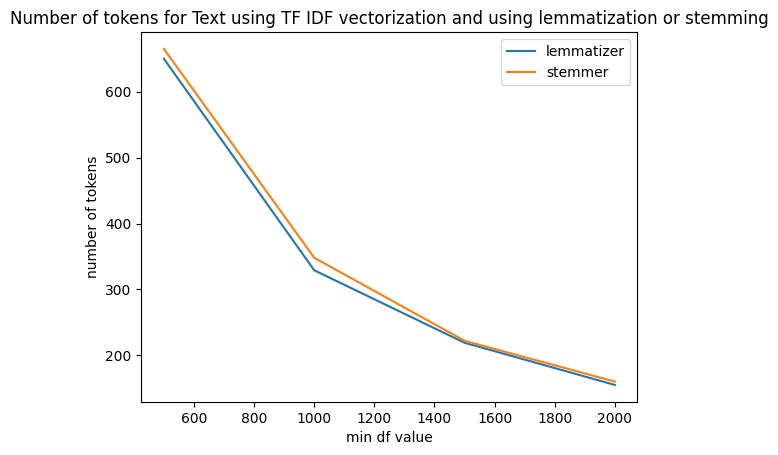

In [ ]:
# plot num tokens for each tokenizer with varying min df values for Text

plt.figure()
plt.plot(min_df_list, numTokens_lem, label = 'lemmatizer')
plt.plot(min_df_list, numTokens_stem, label = 'stemmer')
plt.legend()
plt.xlabel('min df value')
plt.ylabel('number of tokens')
plt.title('Number of tokens for Text using TF IDF vectorization and using lemmatization or stemming')
plt.show()

We can see that the rate of tokenization starts to slow down at around 1500 min df. So moving forward, I will use a min_df value of 1000 for reviews. At min df = 1000, lemmatization is slightly lower then stemming so I will choose lemmatization as it will lead to less tokens (ie. less features) which usually is better for modelling.

In [ ]:
min_df_list2 = range(200,1201,200)
numTokens_lem2 = []
numTokens_stem2 = []
datashort = clean_df['Summary'].sample(n = 50000, random_state = 1)

for i in min_df_list2:

    # number of tokens using tf idf vectorizer using lemmatization or stemming
    print(f'beginning tokenization with min_df = {i}')
    tokens_l = (tfidf(datashort, tokenizer = spl_tokenizer, min_df = i, ngram_range = (1,2))).shape[1]
    print(f'vectorization with lemmatization for min_df = {i} complete')
    tokens_s = (tfidf(datashort, tokenizer = sps_tokenizer, min_df = i, ngram_range = (1,2))).shape[1]
    print(f'vectorization with stemming for min_df = {i} complete')

    numTokens_lem2.append(tokens_l)
    numTokens_stem2.append(tokens_s)
    print(f'number of tokens appending to corresponding list. min_df = {i} complete')

beginning tokenization with min_df = 200
vectorization with lemmatization for min_df = 200 complete
vectorization with stemming for min_df = 200 complete
number of tokens appending to corresponding list. min_df = 200 complete
beginning tokenization with min_df = 400
vectorization with lemmatization for min_df = 400 complete
vectorization with stemming for min_df = 400 complete
number of tokens appending to corresponding list. min_df = 400 complete
beginning tokenization with min_df = 600
vectorization with lemmatization for min_df = 600 complete
vectorization with stemming for min_df = 600 complete
number of tokens appending to corresponding list. min_df = 600 complete
beginning tokenization with min_df = 800
vectorization with lemmatization for min_df = 800 complete
vectorization with stemming for min_df = 800 complete
number of tokens appending to corresponding list. min_df = 800 complete
beginning tokenization with min_df = 1000
vectorization with lemmatization for min_df = 1000 com

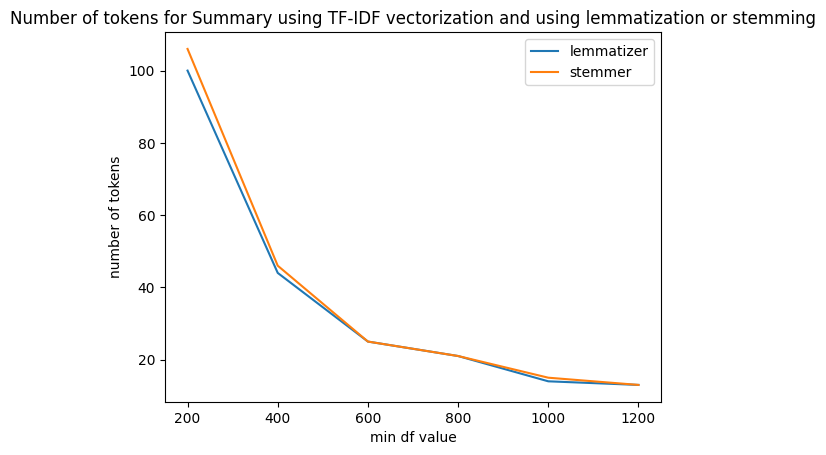

In [ ]:
# plot num tokens for each tokenizer with varying min df values for Summary

plt.figure()
plt.plot(min_df_list2, numTokens_lem2, label = 'lemmatizer')
plt.plot(min_df_list2, numTokens_stem2, label = 'stemmer')
plt.legend()
plt.xlabel('min df value')
plt.ylabel('number of tokens')
plt.title('Number of tokens for Summary using TF-IDF vectorization and using lemmatization or stemming')
plt.show()

For summary, rate of descent slows down at around 400 so I will use a min df value of 400. Again, lemmatization produces a slightly lower numbewr of tokens compared to stemming so I will use lemmatization.

**Scaling non-token Features**

To determine the optimal scaling for the non-token features.

We will need to scale features as clustering methods are distance sensitive.

In [7]:
#@title grab all the numeric features (no tokens)

df2 = clean_df.select_dtypes(include = ['int32','int64','float64'])
df2.drop('Unnamed: 0', axis = 1, inplace = True)
df2.drop('Id', axis = 1, inplace = True)

In [8]:
df2.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,inconsistent_name,time_delta,nameProvided,User_five_star_only,User_one_star_only,Summary_word_count,Text_word_count
0,0,0,5,0,0.0,1,1,0,4,74
1,2,2,5,0,0.0,1,1,0,12,78
2,0,0,5,0,0.0,1,1,0,2,29
3,1,2,5,1,0.0,1,1,0,5,36
4,1,2,5,1,0.0,1,1,0,5,36


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [10]:
# instantiate min max scaler
mm = MinMaxScaler()

df3 = mm.fit_transform(df2)
pd.DataFrame(df3, columns = df2.columns).describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,inconsistent_name,time_delta,nameProvided,User_five_star_only,User_one_star_only,Summary_word_count,Text_word_count
count,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000
mean,0.002014,0.002415,0.795800,0.691460,0.000450,0.999944,0.469282,0.063928,0.075963,0.022533
std,0.008818,0.008981,0.327609,0.461891,0.010523,0.007503,0.499056,0.244624,0.063486,0.023172
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.750000,0.000000,0.000000,1.000000,0.000000,0.000000,0.024390,0.008749
50%,0.000000,0.001083,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.073171,0.015456
75%,0.002309,0.002167,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.097561,0.027705
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The min max scaler bounds all features between 0 and 1. It is good as it doesn't distort the data and keeps the lower and upper bounds consistent which helps when performing clustering as the scales of all the features are the same.

In [ ]:
rs = RobustScaler(with_centering = False)
df4 = rs.fit_transform(df2)
pd.DataFrame(df4, columns = df2.columns).describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,inconsistent_name,time_delta,nameProvided,User_five_star_only,User_one_star_only,Summary_word_count,Text_word_count
count,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000
mean,0.871909,1.114405,4.183199,0.691460,0.836604,0.999944,0.469282,0.063928,1.371493,1.234831
std,3.818256,4.144870,1.310436,0.461891,19.563154,0.007503,0.499056,0.244624,0.867640,1.222391
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.046154
25%,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.666667,0.507692
50%,0.000000,0.500000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.333333,0.861538
75%,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.666667,1.507692
max,433.000000,461.500000,5.000000,1.000000,1859.000000,1.000000,1.000000,1.000000,14.000000,52.800000


The robust scaler is not a good candidate as the scales are different for the features.

In [ ]:
ss = StandardScaler()
df5 = ss.fit_transform(df2)
pd.DataFrame(df5, columns = df2.columns).describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,inconsistent_name,time_delta,nameProvided,User_five_star_only,User_one_star_only,Summary_word_count,Text_word_count
count,5.684540e+05,5.684540e+05,5.684540e+05,5.684540e+05,5.684540e+05,5.684540e+05,5.684540e+05,5.684540e+05,5.684540e+05,5.684540e+05
mean,-1.419951e-17,5.919794e-17,3.756369e-16,6.019790e-17,-2.149925e-18,-1.012040e-15,-2.969896e-17,-5.399812e-17,1.317954e-16,-7.529738e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.283528e-01,-2.688639e-01,-2.429116e+00,-1.497019e+00,-4.276432e-02,-1.332786e+02,-9.403395e-01,-2.613305e-01,-1.196534e+00,-9.724211e-01
25%,-2.283528e-01,-2.688639e-01,-1.397999e-01,-1.497019e+00,-4.276432e-02,7.503080e-03,-9.403395e-01,-2.613305e-01,-8.123500e-01,-5.948504e-01
50%,-2.283528e-01,-1.482328e-01,6.233056e-01,6.679940e-01,-4.276432e-02,7.503080e-03,-9.403395e-01,-2.613305e-01,-4.398102e-02,-3.053795e-01
75%,3.354709e-02,-2.760162e-02,6.233056e-01,6.679940e-01,-4.276432e-02,7.503080e-03,1.063446e+00,-2.613305e-01,3.402034e-01,2.232195e-01
max,1.131743e+02,1.110737e+02,6.233056e-01,6.679940e-01,9.498290e+01,7.503080e-03,1.063446e+00,3.826572e+00,1.455503e+01,4.218391e+01


As we have seen previously, the data is heavily skewed and so using a standard scaler can heavily distort the data. The features are on different scales as well.

**Based on the above, the min max scaler seems to be the best as it brings the values between 0 and 1 while maintaing scale. The robust and standard scalers distort the data since the data is heavily skewed.**

In [11]:
#@title get tfidf tokens

'''rs = 1
sampleText = clean_df['Text'].sample(n = 50000, random_state = rs)
sampleSummary = clean_df['Summary'].sample(n = 50000, random_state = rs)
'''
# to get text tokens which will be prepended with 'r_'
text_tokens = tfidf(clean_df['Text'], tokenizer = spl_tokenizer, ngram_range = (1,2), min_df = 1000)
# to get summary tokens which will be prepended with 's_'
# summary_tokens = tfidf(clean_df['Summary'], tokenizer = spl_tokenizer, ngram_range = (1,2), min_df = 400)

In [12]:
# put the scaled into a dataframe
df_scaled = pd.DataFrame(df3, columns = df2.columns)
df_scaled.shape

(568454, 10)

In [13]:
del df3, df2 # save memory

In [ ]:
# concatenate the scaled non-token features and the review & summary tokens
df_final = pd.concat([df_scaled, text_tokens, summary_tokens], axis = 1)
df_final.to_csv('all_tokens_scaled.csv', index=False)
df_final.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,inconsistent_name,time_delta,nameProvided,User_five_star_only,User_one_star_only,Summary_word_count,Text_word_count,...,s_wrong,s_year,s_yes,s_yet,s_youll,s_youre,s_yuck,s_yum,s_yum s_yum,s_yummy
0,0.000000,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.073171,0.020706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002309,0.002167,1.0,0.0,0.0,1.0,1.0,0.0,0.268293,0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.024390,0.007582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001155,0.002167,1.0,1.0,0.0,1.0,1.0,0.0,0.097561,0.009624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001155,0.002167,1.0,1.0,0.0,1.0,1.0,0.0,0.097561,0.009624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_final1 = pd.concat([df_scaled, text_tokens], axis = 1)
df_final1.to_csv('text_tokens_scaled.csv', index=False)
df_final1.shape

(568454, 3333)

In [15]:
#del text_tokens, summary_tokens, df_scaled # save memory
del text_tokens, df_scaled # save memory

# PCA

In [ ]:
#df_final = pd.read_csv('all_tokens_scaled.csv')
df_final1 = pd.read_csv('text_tokens_scaled.csv')

In [17]:
df_final1.tail()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,inconsistent_name,time_delta,nameProvided,User_five_star_only,User_one_star_only,Summary_word_count,Text_word_count,...,r_youve,r_yr,r_yr r_old,r_yuck,r_yum,r_yummy,r_zero,r_zico,r_zip,r_zukes
568449,0.0,0.0,0.75,1.0,0.0,1.0,0.0,0.0,0.146341,0.052785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568450,0.0,0.0,1.00,1.0,0.0,1.0,1.0,0.0,0.024390,0.011665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568451,0.0,0.0,1.00,1.0,0.0,1.0,0.0,0.0,0.219512,0.041120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568452,0.0,0.0,1.00,0.0,0.0,1.0,1.0,0.0,0.024390,0.006124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568453,0.0,0.0,1.00,0.0,0.0,1.0,1.0,0.0,0.097561,0.006416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_final1.shape

(568454, 3333)

In [19]:
#@title PCA (IncrementalPCA)

from sklearn.decomposition import IncrementalPCA

# Define the batch size (number of samples to process at a time)
batch_size = 1000
num_features = 3333
# Create an IPCA instance
ipca = IncrementalPCA(n_components = 400)

# Initialize an empty array to store the principal components
pcs = np.empty((0, 400))

# Open the file and read it in batches
with open('text_tokens_scaled.csv', 'r') as file:
    header = file.readline()  # Skip the header
    data_batch = np.empty((0, num_features))  # Initialize an empty batch

    for line in file:
        # Process each line and convert it to a numpy array
        sample = np.fromstring(line.strip(), sep=',')

        # Append the sample to the batch
        data_batch = np.vstack((data_batch, sample))

        # If the batch size is reached, perform IPCA on the batch
        if len(data_batch) == batch_size:
            ipca.partial_fit(data_batch)
            pcs_batch = ipca.transform(data_batch)
            pcs = np.vstack((pcs, pcs_batch))
            data_batch = np.empty((0, num_features))  # Reset the batch

    # Perform IPCA on the remaining samples (less than the batch size)
    ipca.partial_fit(data_batch)
    pcs_batch = ipca.transform(data_batch)
    pcs = np.vstack((pcs, pcs_batch))

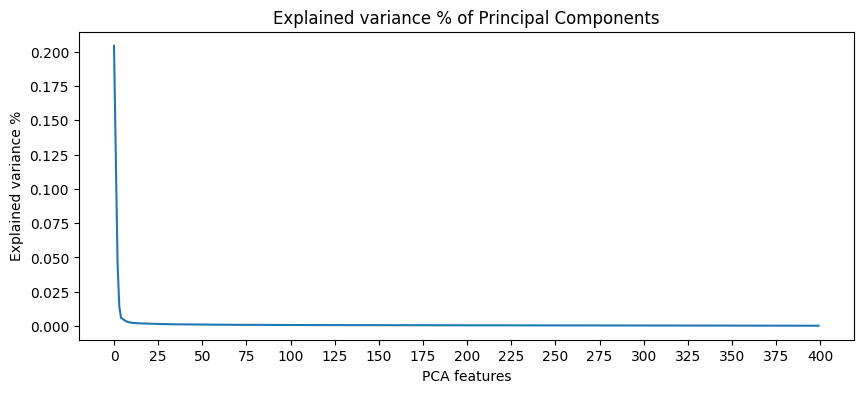

In [ ]:
# Plot the explained variances
plt.figure(figsize=(10, 4))
plt.plot(range(400), ipca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('Explained variance %')
plt.xticks(range(0, 401, 25))
plt.title('Explained variance % of Principal Components')
plt.show()

In [ ]:
# Create a PCA instance: pca
#pca = PCA(n_components = 400)
#pcs = pca.fit_transform(df_final)

# file is too big to use original PCA!

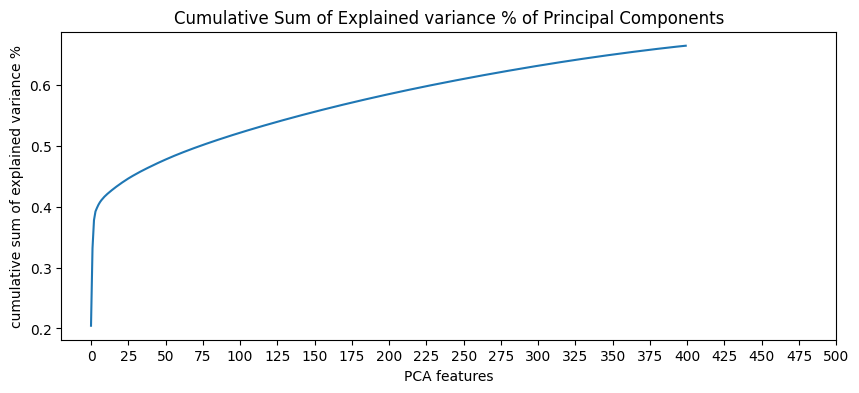

In [ ]:
# Plot the cumulative sum of explained variances
plt.figure(figsize=(10,4))
plt.plot(range(400), ipca.explained_variance_ratio_.cumsum()[0:400])
plt.xlabel('PCA features')
plt.ylabel('cumulative sum of explained variance %')
plt.xticks(range(0,501,25))
plt.title('Cumulative Sum of Explained variance % of Principal Components')
plt.show()

From the above, we want to have as much explained variance as possible from the least number of principal components. As a rough guide, I want to be able to have at least 90% explained variance.

In [20]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(pcs)
PCA_components.to_csv('PCA_components.csv', index=False)

In [ ]:
#explained variance for 300 PCs
ipca.explained_variance_ratio_.cumsum()[300]

0.6318999664273117

In [22]:
#explained variance for 350 PCs
ipca.explained_variance_ratio_.cumsum()[350]

0.6502588822051865

In [ ]:
#explained variance for 399 PCs
ipca.explained_variance_ratio_.cumsum()[399]

0.6648120514760434

use **350 PCs** and get a decent tradeoff: 50 more features for 2% increase in explained variance compared to 300 PCs.

# KMean

In [21]:
from sklearn.cluster import KMeans

In [ ]:
k_values = range(8, 32)
inertia_scores = []

for k in k_values:
    kmeans_model = KMeans(n_clusters = k, verbose = 1)
    kmeans_model.fit(PCA_components.iloc[:, 0:350])
    inertia = kmeans_model.inertia_
    inertia_scores.append(inertia)

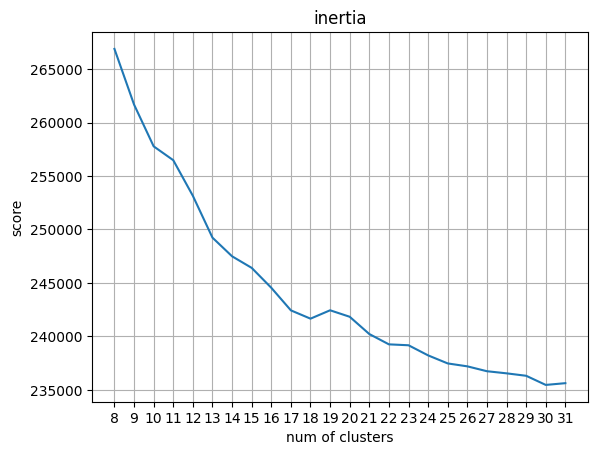

In [ ]:
plt.figure()
plt.plot(k_values, inertia_scores)
plt.xlabel('num of clusters')
plt.ylabel('score')
plt.title('inertia')
plt.xticks(k_values)
plt.grid()
# plt.ylim(0, 580000)
plt.show()

Based on the graph, there is a decrease in the slope at the following number of clusters: 18.

In [23]:
#@title KMeans with 18 clusters
kmeans_model18 = KMeans(n_clusters = 18, verbose = 1)
kmeans_model18.fit(PCA_components.iloc[:, 0:350])

Initialization complete
Iteration 0, inertia 426218.2860917036.
Iteration 1, inertia 256303.92877742776.
Iteration 2, inertia 254208.83671752713.
Iteration 3, inertia 253454.44021310133.
Iteration 4, inertia 252771.50755774253.
Iteration 5, inertia 252479.07736753457.
Iteration 6, inertia 252403.34008561794.
Iteration 7, inertia 252138.73477900756.
Iteration 8, inertia 251962.63073747838.
Iteration 9, inertia 251864.31656040993.
Iteration 10, inertia 251651.8801132323.
Iteration 11, inertia 251141.99462445505.
Iteration 12, inertia 250862.78845917934.
Iteration 13, inertia 250806.52826909366.
Iteration 14, inertia 250805.08325298518.
Iteration 15, inertia 250803.5649609031.
Iteration 16, inertia 250801.49076414428.
Iteration 17, inertia 250798.79035163386.
Iteration 18, inertia 250794.94039413467.
Iteration 19, inertia 250789.8738837613.
Iteration 20, inertia 250783.37484641225.
Iteration 21, inertia 250774.67111039782.
Iteration 22, inertia 250762.9500664254.
Iteration 23, inertia 250

KMeans(n_clusters=18, verbose=1)

In [24]:
import joblib

joblib.dump(kmeans_model18, 'kmeans_model18.pkl')

['kmeans_model18.pkl']

In [25]:
# get 2 matrices
# 1) data with principal components (PCs)
# 2) PCs and features
# only getting 350 PCs as those the model was fit only on those PCs
data_pc_matrix = PCA_components.iloc[:, 0:350].to_numpy()
pc_feature_matrix = ipca.components_[0:350, :]

In [26]:
# matrix multiplication to get the reviews back in terms of the original features
# will then save this reconstructed data to a dataframe
df_recon = pd.DataFrame(np.matmul(data_pc_matrix, pc_feature_matrix), columns = df_final1.columns)

In [29]:
del df_final1

In [30]:
# add cluster labels to the reconstructed dataframe
df_recon['cluster'] = kmeans_model18.labels_

In [31]:
text_ = clean_df['Text']

In [ ]:
text_

0         this witty little book makes my son laugh at l...
1         I can remember seeing the show when it aired o...
2         Beetlejuice is a well written movie ..... ever...
3         A twist of rumplestiskin captured on film, sta...
4         A twist of rumplestiskin captured on film, sta...
                                ...                        
568449    The only reason I am giving it 4 stars instead...
568450    Very pleased with the quality of the espresso....
568451    I just love it, and I am Not a major Indian co...
568452    I enjoy drinking this in a greek yogurt smooth...
568453    Aside from a non-flashy name, this is a great ...
Name: Text, Length: 568454, dtype: object

In [32]:
del clean_df

In [33]:
# use same settings used for KMeans clustering to be consistent
vectorizer = TfidfVectorizer(min_df = 1000, tokenizer = spl_tokenizer, ngram_range = (1,2))

In [34]:
word_matrix = vectorizer.fit_transform(text_)

In [35]:
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(",".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

For LDA topic Modelling, we need to pre-select the number of topics we think exist in our text. To be consistent with KMeans clustering, I will choose 18 topics as we had selected 18 clusters for KMeans. Note: this is not necessarily the optimal way to determine the number of topics. Can make improvements in future iterations.

In [36]:
number_topics = 18
number_words = 15

In [54]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=number_topics, n_jobs = 4, verbose = 1)
lda.fit(word_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=18, n_jobs=4, verbose=1)

In [55]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
r_sauce,r_oil,r_hot,r_olive,r_bread,r_flavor,r_like,r_br,r_pepper,r_taste,r_good,r_salad,r_spicy,r_olive r_oil,r_use

Topic #1:
r_chocolate,r_hot,r_cocoa,r_milk,r_taste,r_flavor,r_like,r_dark,r_dark r_chocolate,r_hot r_chocolate,r_cream,r_salt,r_ice,r_good,r_vanilla

Topic #2:
r_sugar,r_taste,r_drink,r_flavor,r_syrup,r_like,r_water,r_br,r_juice,r_soda,r_sweet,r_product,r_good,r_bottle,r_artificial

Topic #3:
r_tea,r_green,r_green r_tea,r_flavor,r_taste,r_drink,r_like,r_bag,r_good,r_tea r_bag,r_br,r_cup,r_black,r_iced,r_stash

Topic #4:
r_br,r_product,r_day,r_review,r_water,r_taste,r_like,r_one,r_im,r_time,r_tea,r_drink,r_work,r_try,r_dont

Topic #5:
r_chip,r_snack,r_calorie,r_flavor,r_bag,r_fat,r_salt,r_like,r_taste,r_potato,r_low,r_great,r_good,r_cooky,r_br

Topic #6:
r_store,r_amazon,r_price,r_find,r_local,r_grocery,r_buy,r_grocery r_store,r_popcorn,r_great,r_product,r_shipping,r_love,r_get,r_save

Topic #7:
r_jerky,r_taste,r_like,r_energy,r_star,r_pr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As we can see above, these are the top words for each topic. The results are pretty good: we can see topics related to specific types of products like topic 1 (cocoa), topic 2 (green tea) and topic 16 (granola bar).

In [56]:
#saving model to computer
joblib.dump(lda,'lda_18.pkl')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['lda_18.pkl']

In [38]:
#import relevant libraries
import pickle
import pyLDAvis
#from pyLDAvis import sklearn as sklearn_lda
import os

In [42]:
#creating file path
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
LDAvis_data_filepath

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'./ldavis_prepared_18'

In [ ]:
# preparing the LDA model to be saved in the LDAvis visualizer
LDAvis_prepared = pyLDAvis.sklearn.prepare(lda, word_matrix, vectorizer)

In [ ]:
#saving LDA model into LDAvis visualization
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#saving LDA model into LDAvis visualization html file
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

# Cluster Analysis

To explore the clusters and try to find a cluster of reviews that shows signs of fake reviews.

signs of fake reviews include:

*   extreme ratings
*   shorter reviews

In [39]:
df_recon.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HelpfulnessNumerator,HelpfulnessDenominator,Score,inconsistent_name,time_delta,nameProvided,User_five_star_only,User_one_star_only,Summary_word_count,Text_word_count,...,r_yr,r_yr r_old,r_yuck,r_yum,r_yummy,r_zero,r_zico,r_zip,r_zukes,cluster
0,0.000379,0.000388,0.212560,-0.490966,-0.000784,0.000093,0.553698,-0.049240,-0.063477,-0.015238,...,0.008794,0.009065,-0.000654,0.004694,0.022639,0.000066,-0.006620,0.000876,-0.002594,1
1,-0.003815,-0.003770,0.221230,-0.488728,-0.002806,0.000116,0.550185,-0.045137,-0.060821,-0.031552,...,0.004961,0.004737,-0.001611,0.004679,0.001552,-0.003057,-0.017923,-0.001484,-0.003430,1
2,0.002146,0.001279,0.531228,-0.404246,0.000670,-0.000082,0.496067,0.364797,0.017489,-0.011294,...,0.000714,0.000330,-0.001465,0.001053,0.006254,-0.001853,0.001419,0.000600,0.001496,1
3,0.003222,0.002739,0.080525,0.478348,-0.000215,-0.000786,0.348574,-0.129746,-0.016020,0.007404,...,-0.002587,-0.002839,-0.000710,0.001565,0.005830,-0.001461,-0.001379,0.002709,-0.000638,17
4,0.003222,0.002739,0.080525,0.478348,-0.000215,-0.000786,0.348574,-0.129746,-0.016020,0.007404,...,-0.002587,-0.002839,-0.000710,0.001565,0.005830,-0.001461,-0.001379,0.002709,-0.000638,17


In [40]:
# get names of non-token features and cluster for analysis
non_tokens_clust = list(df_recon.columns[0:10]) + ['cluster']
# get names of token features and cluster for analysis
tokens_clust = list(df_recon.columns[10:])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# average HelpfulnessNumerator by cluster
df_recon.loc[:, non_tokens_clust].groupby('cluster').mean().iloc[:,0].sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cluster
4     0.001250
14    0.001180
0     0.000534
7     0.000465
10    0.000374
9     0.000374
6     0.000258
13    0.000224
11    0.000110
8     0.000096
2     0.000006
16   -0.000029
5    -0.000067
1    -0.000106
17   -0.000200
15   -0.000292
12   -0.000423
3    -0.000438
Name: HelpfulnessNumerator, dtype: float64

Cluster 4, 14 get more number of users who found their review helpful, while Cluster 12, 3 are the opposite.

In [43]:
# average rating by cluster
df_recon.loc[:,non_tokens_clust].groupby('cluster').mean().iloc[:,2].sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cluster
12    0.400299
3     0.399914
8     0.213815
17    0.203152
5     0.190251
15    0.166291
1     0.165325
9    -0.055413
11   -0.058193
16   -0.141987
10   -0.202908
0    -0.249529
6    -0.396602
2    -0.440559
7    -0.549799
13   -0.622376
4    -0.790859
14   -0.797125
Name: Score, dtype: float64

From here we can see that about Cluster 12, 3 give the highest score. As we know, the data was heavily skewed to high score (ie. 5) so this on its own is not informative. What is interesting though is Cluster 4, 14 has the lowest score.

Cluster 15, 1 have the lowest summary word count.

In [45]:
df_recon.loc[:,non_tokens_clust].groupby('cluster').mean().iloc[:,9].sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cluster
0     0.014473
8     0.010770
2     0.007182
11    0.005743
6     0.005019
5     0.004739
3     0.004540
9     0.003563
10    0.002663
14    0.000887
13    0.000562
16    0.000234
12   -0.000905
4    -0.001093
7    -0.002415
17   -0.003174
1    -0.005647
15   -0.010078
Name: Text_word_count, dtype: float64

Cluster 0, 8 give the highest text word count, while Cluster 1, 15 have the lowest text word count. It seems people who type more text don't necessarily get more 'Helpful!'.

**Top Tokens per cluster**


In [46]:
#getting the mean token value per cluster
df_tokens = df_recon.loc[:,tokens_clust].groupby('cluster').mean()

#now let's print the top 20 review tokens for cluster 15
cluster = 15
print(df_tokens.iloc[cluster,:].sort_values(ascending=False)[0:20])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


r_coffee          0.158237
r_tea             0.100821
r_cup             0.039122
r_strong          0.019969
r_drink           0.018697
r_cup r_coffee    0.016756
r_taste           0.016340
r_great           0.015854
r_green           0.015768
r_roast           0.014904
r_blend           0.014189
r_pod             0.014027
r_bold            0.013466
r_flavor          0.013309
r_keurig          0.013052
r_green r_tea     0.012978
r_bitter          0.012903
r_brew            0.012306
r_smooth          0.012237
r_kcups           0.011445
Name: 15, dtype: float64


There is no clear trend in the top words in Cluster 15.

In [47]:
#now let's print the top 20 review tokens for cluster 1
cluster = 1
print(df_tokens.iloc[cluster,:].sort_values(ascending=False)[0:20])

r_love         0.005854
r_best         0.005496
r_product      0.005208
r_find         0.005059
r_store        0.004944
r_great        0.004765
r_year         0.004429
r_order        0.003363
r_candy        0.003311
r_amazon       0.003243
r_dog          0.003101
r_gift         0.003083
r_thank        0.002926
r_ever         0.002895
r_delicious    0.002842
r_arrived      0.002787
r_happy        0.002586
r_thanks       0.002466
r_friend       0.002390
r_online       0.002020
Name: 1, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster 1 includes some personal information.

In [48]:
#now let's print the top 20 review tokens for cluster 12
cluster = 12
print(df_tokens.iloc[cluster,:].sort_values(ascending=False)[0:20])

r_coffee       0.013399
r_love         0.010630
r_great        0.010380
r_best         0.006413
r_good         0.005219
r_favorite     0.005168
r_chip         0.004989
r_bar          0.004959
r_snack        0.004833
r_chocolate    0.004340
r_delicious    0.004311
r_find         0.003498
r_flavor       0.003294
r_perfect      0.003276
r_keep         0.003005
r_free         0.002698
r_treat        0.002669
r_healthy      0.002531
r_excellent    0.002523
r_wonderful    0.002458
Name: 12, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are more general positive terms in this cluster. This fits that fake reviews which would use more general postive terms and lacking personal details.

In [49]:
#now let's print the top 20 review tokens for cluster 3
cluster = 3
print(df_tokens.iloc[cluster,:].sort_values(ascending=False)[0:20])

r_tea            0.173554
r_food           0.048963
r_dog            0.046257
r_cat            0.044776
r_green r_tea    0.025770
r_green          0.024081
r_treat          0.021257
r_love           0.018877
r_tea r_bag      0.013719
r_dog r_food     0.012596
r_bag            0.011241
r_cat r_food     0.011074
r_stash          0.010405
r_black r_tea    0.010217
r_dog r_love     0.010209
r_iced           0.008869
r_love r_tea     0.008640
r_drink          0.008413
r_iced r_tea     0.008260
r_black          0.008196
Name: 3, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There is no clear trend in the top words in Cluster 3.

In [52]:
# top 20 review tokens for cluster 8
cluster = 8
print(df_tokens.iloc[cluster,:].sort_values(ascending=False)[0:20])

r_br         0.026082
r_good       0.016244
r_flavor     0.010872
r_little     0.009184
r_really     0.009142
r_tea        0.008760
r_nice       0.007925
r_cracker    0.007278
r_like       0.006572
r_sweet      0.006528
r_tasty      0.006430
r_get        0.006176
r_add        0.006122
r_bit        0.005850
r_calorie    0.005806
r_pretty     0.005721
r_make       0.005702
r_mix        0.005451
r_candy      0.005315
r_soup       0.005177
Name: 8, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There is no clear trend in the top words in Cluster 8.

In [53]:
# top 20 review tokens for cluster 0
cluster = 0
print(df_tokens.iloc[cluster,:].sort_values(ascending=False)[0:20])

r_tea            0.239403
r_food           0.041435
r_dog            0.035510
r_green          0.035420
r_green r_tea    0.035023
r_cat            0.033304
r_br             0.022934
r_tea r_bag      0.019806
r_bag            0.019518
r_drink          0.015621
r_stash          0.014332
r_black r_tea    0.014094
r_black          0.013846
r_cup            0.013489
r_iced           0.012822
r_leaf           0.012414
r_iced r_tea     0.011165
r_dog r_food     0.010612
r_treat          0.010493
r_earl           0.010488
Name: 0, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There is no clear trend in the top words in Cluster 0.

In [50]:
# top 20 review tokens for cluster 4
cluster = 4
print(df_tokens.iloc[cluster,:].sort_values(ascending=False)[0:20])

r_product          0.017710
r_money            0.013521
r_box              0.012089
r_received         0.011388
r_disappointed     0.010989
r_item             0.010461
r_return           0.010247
r_waste            0.010034
r_waste r_money    0.008624
r_ordered          0.008100
r_worst            0.008078
r_horrible         0.007789
r_bad              0.007653
r_company          0.006851
r_terrible         0.006788
r_buy              0.006776
r_never            0.006729
r_would            0.006487
r_awful            0.006436
r_opened           0.006074
Name: 4, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster 4 gives more negative word, cinsistent with the lowest score it gives.

In [51]:
# the top 20 review tokens for cluster 14
cluster = 14
print(df_tokens.iloc[cluster,:].sort_values(ascending=False)[0:20])

r_money            0.012538
r_product          0.010764
r_box              0.010267
r_return           0.010158
r_waste            0.009861
r_disappointed     0.009765
r_received         0.008634
r_company          0.008388
r_worst            0.008373
r_horrible         0.008354
r_waste r_money    0.008347
r_even             0.008335
r_bad              0.007777
r_item             0.007740
r_dog              0.007542
r_ordered          0.007476
r_awful            0.007028
r_terrible         0.007025
r_away             0.006849
r_would            0.006546
Name: 14, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Same as Cluster 4.

It seems that Cluster 12 contain general positive terms.

This means these reviews aren't necessarily fake but they may be unreliable because the reviews in this cluster so seemingly the reviewers are more incentivized to give good reviews even though they claim to be giving unbiased reviews.

In [57]:
clustercol = df_recon.iloc[:, -1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
clustercol.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


568449    11
568450    17
568451     5
568452     1
568453    15
Name: cluster, dtype: int32

In [59]:
clustercol.to_csv('clustercol.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
df_recon.to_csv('df_recon.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
clustercol.value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1     105661
12     83526
10     78659
6      57910
17     55501
5      32628
2      22395
11     21522
7      18680
0      12767
16     11932
3      11753
9      10990
15     10324
8       9671
4       8948
13      8856
14      6731
Name: cluster, dtype: int64

# supervised one


In [ ]:
# functions for df['Text'] pre-processing

def clean_text(text):
    nopunc = [w for w in text if w not in string.punctuation]
    nopunc = ''.join(nopunc)
    return  ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def preprocess(text):
    return ' '.join([word for word in word_tokenize(text) if word not in stopwords.words('english') and not word.isdigit() and word not in string.punctuation])

In [ ]:
df['Text_clean'] = df['Text'].apply(clean_text)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_clean
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several Vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted Peanutsth...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient Robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy great price wide assortment yummy ...


In [ ]:
df["Text_lemmatized"] = df["Text"].apply(lambda text: lemmatize_words(text))
df.head()

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x7fcda5211820>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/nltk/data.py", line 1160, in __del__
    if not self.closed:
  File "/opt/anaconda3/lib/python3.9/site-packages/nltk/data.py", line 1180, in closed
    return self.stream.closed
AttributeError: 'SeekableUnicodeStreamReader' object has no attribute 'stream'


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_clean,Text_lemmatized
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several Vitality canned dog food produc...,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted Peanutsth...,Product arrived labeled a Jumbo Salted Peanuts...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,This is a confection that ha been around a few...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient Robitussin believe f...,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy great price wide assortment yummy ...,Great taffy at a great price. There wa a wide ...


In [ ]:
#df.to_csv('Preprocessed Fake Reviews Detection Dataset.csv')
#df = pd.read_csv('Preprocessed Fake Reviews Detection Dataset.csv')

In [ ]:
df['length_text_lemma'] = df['Text_lemmatized'].apply(len)

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568411 non-null  int64 
 1   ProductId               568411 non-null  object
 2   UserId                  568411 non-null  object
 3   ProfileName             568411 non-null  object
 4   HelpfulnessNumerator    568411 non-null  int64 
 5   HelpfulnessDenominator  568411 non-null  int64 
 6   Score                   568411 non-null  int64 
 7   Time                    568411 non-null  int64 
 8   Summary                 568411 non-null  object
 9   Text                    568411 non-null  object
 10  Text_clean              568411 non-null  object
 11  Text_lemmatized         568411 non-null  object
 12  length_text_lemma       568411 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 60.7+ MB


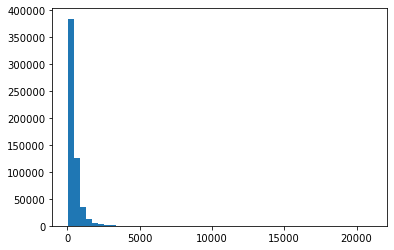

In [ ]:
plt.hist(df['length_text_lemma'], bins=50)
plt.show()

In [ ]:
df.groupby('Score').describe()

Id                                                          \
          count           mean            std   min       25%       50%   
Score                                                                     
1       52264.0  282277.896047  162999.775724   2.0  141642.0  282779.0   
2       29743.0  280775.355277  164674.039652   4.0  137488.0  278370.0   
3       42638.0  279643.956893  165442.055898  46.0  136107.5  274962.0   
4       80655.0  281713.258608  164763.768874   3.0  138555.0  279489.0   
5      363111.0  285887.479828  163879.149969   1.0  144355.5  287334.0   

                          HelpfulnessNumerator            ...          Time  \
            75%       max                count      mean  ...           75%   
Score                                                     ...                 
1      421112.5  568434.0              52264.0  2.735133  ...  1.334362e+09   
2      422768.0  568451.0              29743.0  1.859799  ...  1.333757e+09   
3      425009.5  568423.0              42638.0  1.701018  ...  1.333498e+09   
4      425010.0  568440.0              80655.0  1.390292  ...  1.333238e+09   
5      427569.5  568454.0             363111.0  1.675273  ...  1.332029e+09   

                    length_text_lemma                                       \
                max             count        mean         std   min    25%   
Score                                                                        
1      1.351210e+09           52264.0  471.632366  514.037832  12.0  199.0   
2      1.351210e+09           29743.0  484.312679  452.527762  32.0  209.0   
3      1.351210e+09           42638.0  513.334279  501.288227  32.0  211.0   
4      1.351210e+09           80655.0  489.878234  478.109750  33.0  193.0   
5      1.351210e+09          363111.0  396.830834  405.435846  18.0  167.0   

                              
         50%    75%      max  
Score                         
1      333.0  556.0  11661.0  
2      353.0  597.0   9195.0  
3      368.0  646.0  21070.0  
4      342.0  614.0  12290.0  
5      273.0  474.0  16670.0  

[5 rows x 40 columns]

In [ ]:
CountVectorizer = CountVectorizer(analyzer = 'word')
CountVectorizer.fit(df['Text_lemmatized'])
print("Total Vocabulary:", len(CountVectorizer.vocabulary_))

Total Vocabulary: 118807


In [ ]:
CountVectorizer_text = CountVectorizer.transform(df['Text_lemmatized'])

print("Shape of Bag of Words Transformer for the entire reviews corpus:", CountVectorizer_text.shape)
print("Amount of non zero values in the bag of words model:", CountVectorizer_text.nnz)
print("Sparsity:",np.round((CountVectorizer_text.nnz/(CountVectorizer_text.shape[0]*CountVectorizer_text.shape[1]))*100,2))

Shape of Bag of Words Transformer for the entire reviews corpus: (568411, 118807)
Amount of non zero values in the bag of words model: 30342850
Sparsity: 0.04


In [ ]:
tfidf_transformer = TfidfTransformer().fit(CountVectorizer_text)
tfidf_text = tfidf_transformer.transform(CountVectorizer_text)
print("Shape:", tfidf_text.shape)
print("No. of Dimensions:", tfidf_text.ndim)

Shape: (568411, 118807)
No. of Dimensions: 2


In [ ]:
text_train, text_test, score_train, score_test = train_test_split(df['Text_lemmatized'], df['Score'], test_size = 0.2)

In [ ]:
# MultinomialNB

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = 'word')),
    ('tfidf',TfidfTransformer()),
    ('classifier', MultinomialNB())
])
pipeline.fit(text_train, score_train)
MultiNB_pred = pipeline.predict(text_test)

print('Classification Report:', classification_report(score_test, MultiNB_pred))
print('Confusion Matrix:', confusion_matrix(score_test, MultiNB_pred))
print('Accuracy:', str(np.round(accuracy_score(score_test, MultiNB_pred)*100, 2)) + '%')

In [ ]:
# RandomForest

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = 'word')),
    ('tfidf',TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])
pipeline.fit(text_train, score_train)
RF_pred = pipeline.predict(text_test)
print('Classification Report:', classification_report(score_test, RF_pred))
print('Confusion Matrix:', confusion_matrix(score_test, RF_pred))
print('Accuracy:', str(np.round(accuracy_score(score_test, RF_pred)*100, 2)) + '%')

In [ ]:
# DecisionTree

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = 'word')),
    ('tfidf',TfidfTransformer()),
    ('classifier', DecisionTreeClassifier())
])
pipeline.fit(text_train, score_train)
DT_pred = pipeline.predict(text_test)
print('Classification Report:', classification_report(score_test, DT_pred))
print('Confusion Matrix:', confusion_matrix(score_test, DT_pred))
print('Accuracy:', str(np.round(accuracy_score(score_test, DT_pred)*100, 2)) + '%')

In [ ]:
# SVC

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = 'word')),
    ('tfidf',TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])
pipeline.fit(text_train, score_train)
SVC_pred = pipeline.predict(text_test)
print('Classification Report:', classification_report(score_test, SVC_pred))
print('Confusion Matrix:', confusion_matrix(score_test, SVC_pred))
print('Accuracy:', str(np.round(accuracy_score(score_test, SVC_pred)*100, 2)) + '%')

In [ ]:
# LogisticRegression

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = 'word')),
    ('tfidf',TfidfTransformer()),
    ('classifier', LogisticRegression())
])
pipeline.fit(text_train, score_train)
LR_pred = pipeline.predict(text_test)
print('Classification Report:', classification_report(score_test, LR_pred))
print('Confusion Matrix:', confusion_matrix(score_test, LR_pred))
print('Accuracy:', str(np.round(accuracy_score(score_test, LR_pred)*100, 2)) + '%')

In [ ]:
print('Performance of various ML models:')
print('\n')
print('Logistic Regression Prediction Accuracy:', str(np.round(accuracy_score(score_test, LR_pred)*100, 2)) + '%')
print('Decision Tree Classifier Prediction Accuracy:', str(np.round(accuracy_score(score_test, DT_pred)*100, 2)) + '%')
print('Random Forests Classifier Prediction Accuracy:', str(np.round(accuracy_score(score_test, RF_pred)*100, 2)) + '%')
print('Support Vector Machines Prediction Accuracy:', str(np.round(accuracy_score(score_test, SVC_pred)*100, 2)) + '%')
print('Multinomial Naive Bayes Prediction Accuracy:', str(np.round(accuracy_score(score_test, MultiNB_pred)*100, 2)) + '%')
